In [136]:
import hashlib
import os
import random

from PIL import Image, ImageDraw, ImageFont


def calculate_image_size(text, img_font):
    temp_image = Image.new('RGB', (1, 1), color=(255, 255, 255))
    temp_draw = ImageDraw.Draw(temp_image)

    text_bbox = temp_draw.textbbox((0, 0), text, font=img_font)

    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    return text_width, text_height


def draw_text(text, img_font, background=(255, 255, 255)):
    padding = img_font.size // 2
    text_width, text_height = calculate_image_size(text, img_font)
    image = Image.new('RGB', (text_width + padding, text_height + padding), color=background)
    draw = ImageDraw.Draw(image)
    draw.text((0, -img_font.size / 10), text, font=img_font, fill=(0, 0, 0))
    return image


def apply_aging_effect(image, aging_factor=(0.5, 0.1, 0.005)):
    image = image.convert('L')
    black_factor, gray_factor, white_factor = aging_factor

    pixel_data = list(image.getdata())
    for i in range(len(pixel_data)):
        pixel_value = pixel_data[i]

        if pixel_value < 85:
            if random.random() > black_factor:
                continue
            new_value = pixel_value + random.randint(0, 20) * 10  # увеличиваем яркость 
        elif pixel_value < 170:
            if random.random() > gray_factor:
                continue
            new_value = pixel_value + random.randint(-20, 20) * 10  # меняем яркость 
        else:
            if random.random() > white_factor:
                continue
            new_value = pixel_value + random.randint(-20, 0) * 10  # уменьшаем яркость

        pixel_data[i] = new_value

    image.putdata(pixel_data)
    return image


def apply_printer_grain(image, grain_intensity=1):
    # Убедимся, что изображение в градациях серого
    if image.mode != 'L':
        image = image.convert('L')

    # Создаем шумовое изображение того же размера и режима, что и исходное
    noise_image = Image.new('L', image.size)

    # Заполняем шумовое изображение случайными значениями
    noise_image.putdata([random.randint(0, 255) for _ in range(image.size[0] * image.size[1])])

    # Применяем фильтр размытия к шуму
    # noise_image = noise_image.filter(ImageFilter.GaussianBlur(radius=grain_intensity))

    # Смешиваем исходное изображение со шумом
    combined = Image.blend(image, noise_image, alpha=0.5)

    return combined


def generate_file_name(text, img_font):
    text_md5 = hashlib.md5(text.encode('utf-8')).hexdigest()
    font_name = img_font.path.split('/')[-1].split('.')[0]
    font_md5 = hashlib.md5(font_name.encode('utf-8')).hexdigest()
    return f'{font_md5}_{text_md5}', font_name, text_md5


def generate_image(text, img_font, aging_factor=(0.5, 0.1, 0.005), directory='../fonts'):
    file_name, font_name, text_name = generate_file_name(text, img_font)
    if os.path.exists(os.path.join(directory, f'{file_name}.png')):
        return

    image = draw_text(text, img_font)
    image = apply_aging_effect(image, aging_factor)
    # image = apply_printer_grain(image, grain_intensity=0.5)

    return image, file_name.split('_')[0]

In [139]:
FONT_SIZE = 40
FONT_DIR = '../data/tesstrain/kbd/fonts'

fonts_files = [f'{FONT_DIR}/{font}' for font in sorted(os.listdir(FONT_DIR)) if font.endswith('.ttf') or font.endswith('.otf')]
fonts = []
for font_f in fonts_files:
    try:
        img_font = ImageFont.truetype(font_f, FONT_SIZE)
        fonts.append(img_font)
    except OSError:
        print(f'Error loading font {font_f}')
        continue


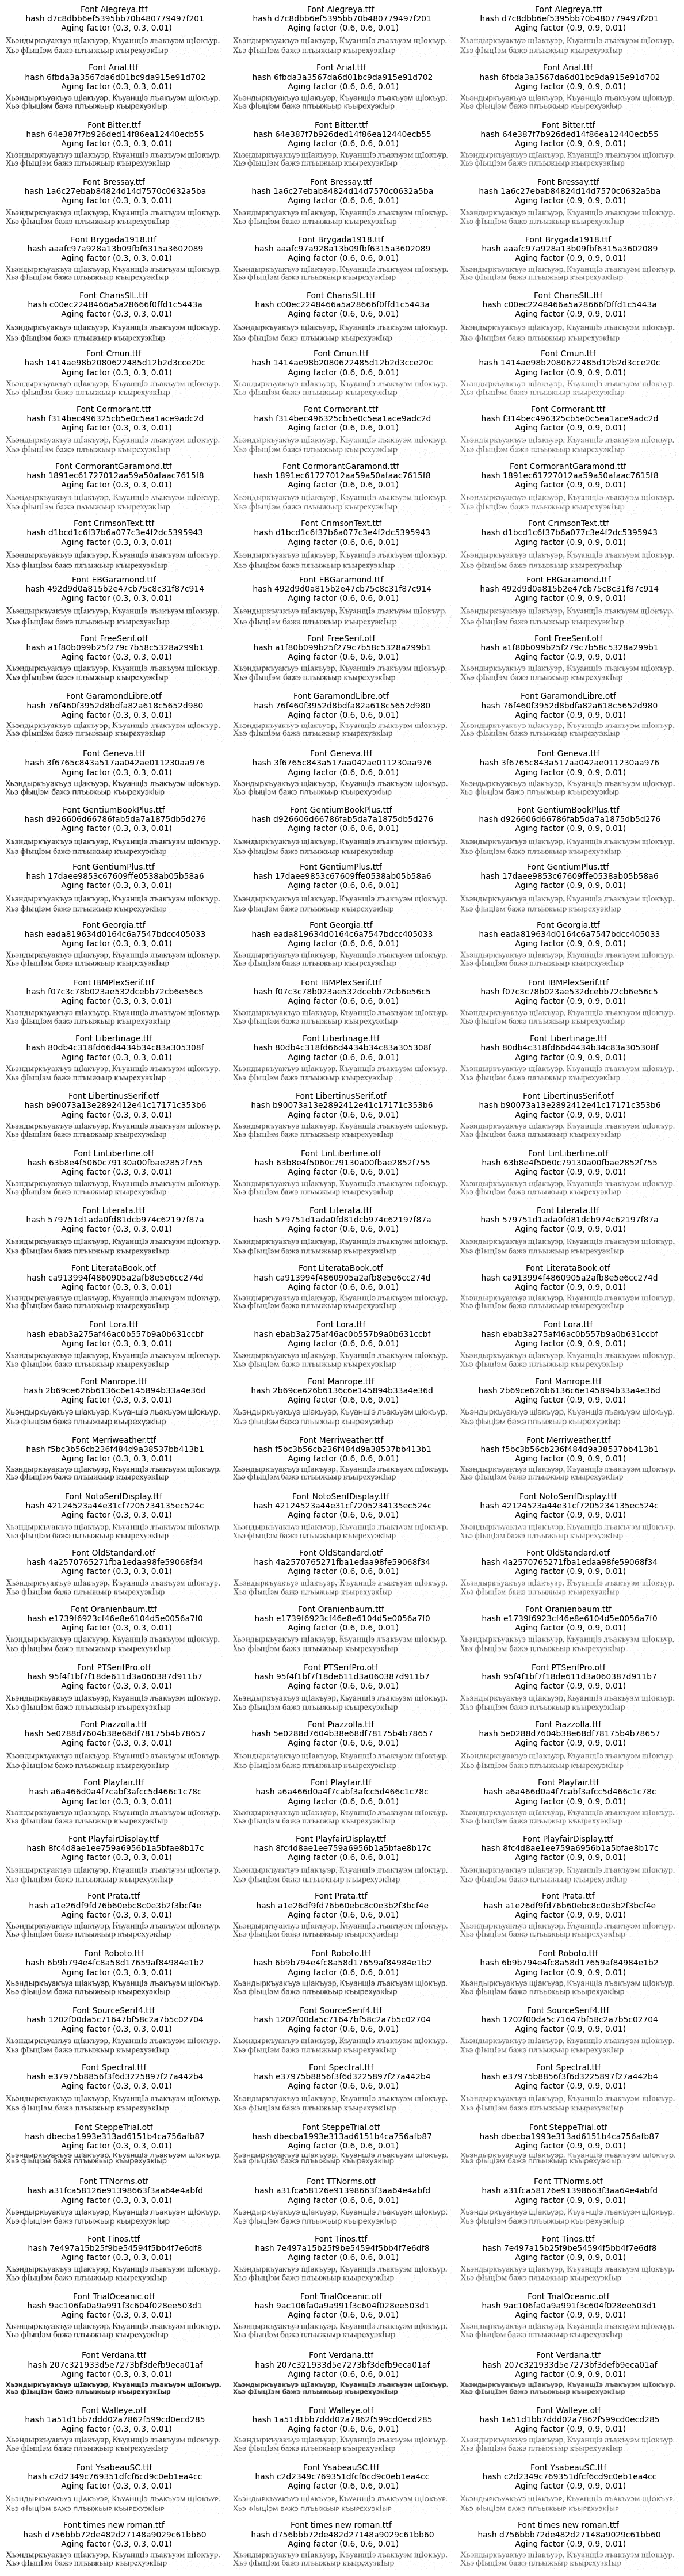

In [140]:
import matplotlib.pyplot as plt

# Параметры старения и шрифты (предполагается, что они определены в вашем скрипте)
aging_factors = [
    (0.3, 0.3, 0.01),
    (0.6, 0.6, 0.01),
    (0.9, 0.9, 0.01),
]

line = ('Хьэндыркъуакъуэ щIакъуэр, КъуанщIэ лъакъуэм щIокъур.\n'
        'Хьэ фIыцIэм бажэ плъыжьыр къырехуэкIыр')
        
# Установка размера сетки для отображения изображений
num_aging_factors = len(aging_factors)
num_fonts = len(fonts)
fig, axes = plt.subplots(num_fonts, num_aging_factors, figsize=(12, len(fonts)))

# Генерация и отображение изображений
for i, font in enumerate(fonts):
    for j, aging_factor in enumerate(aging_factors):
        image, font_name = generate_image(line, font, aging_factor)
        ax = axes[i, j]
        ax.imshow(image, cmap='gray')
        ax.axis('off')  # Отключение осей
        ax.set_title(
            f'Font {font.path.split("/")[-1]} \n '
            f'hash {font_name} \n '
            f'Aging factor {aging_factor}',
            fontsize=10
        )

# Показ графика
plt.tight_layout()
plt.show()
